In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.io import read_image

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [3]:
def image_transform(image):
    image = (image.float() / 255.0 - 0.5) / 0.5
    return image

def mask_transform(mask):
    new_mask = torch.zeros(mask[0].shape, dtype=torch.int64)
    new_mask[torch.logical_and(torch.logical_and(mask[0, :, :] >= 200, mask[1, :, :] >= 200), mask[2, :, :] >= 200)] = 1
    mask = new_mask
    return mask

common_train_transforms = torch.nn.Sequential(
    transforms.Resize(512, antialias=True),
    transforms.RandomCrop(512, padding=64),
    transforms.RandomRotation(45)
)

train_image_transforms = torch.nn.Sequential(
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.3)
)

train_mask_transforms = None

common_val_transforms = torch.nn.Sequential(
    transforms.Resize(512, antialias=True)
)

val_image_transforms = None

val_mask_transforms = None

In [4]:
class ForestRoadsDataset(Dataset):

    def __init__(self, csv_file, root_dir, common_transform=None, img_transform=None, m_transform=None, max_len=None):
        
        self.image_mask_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.common_transform = common_transform
        self.img_transform = img_transform
        self.m_transform = m_transform
        self.max_len = len(self.image_mask_df)
        if max_len != None:
            self.max_len = max_len

    def __len__(self):
        return self.max_len

    def __getitem__(self, index):

        img_name = os.path.join(self.root_dir,
                                self.image_mask_df.iloc[index, 0])
        m_name = os.path.join(self.root_dir,
                                self.image_mask_df.iloc[index, 1])
        
        image = read_image(img_name)
        mask = read_image(m_name)
        if self.common_transform:
            image_mask = torch.cat((image.unsqueeze(0), mask.unsqueeze(0)), 0)
            image_mask = self.common_transform(image_mask)
            image = image_mask[0]
            mask = image_mask[1]

        if self.img_transform:
            image = self.img_transform(image)
        image = image_transform(image)
            
        if self.m_transform:
            mask = self.m_transform(mask)
        mask = mask_transform(mask)
            
        return image, mask

In [11]:
train_dataset = ForestRoadsDataset('/kaggle/input/coursework/data/train/train_info.csv', 
                                   '/kaggle/input/coursework/data/train', 
                                   common_train_transforms, train_image_transforms, train_mask_transforms, 8000)
val_dataset = ForestRoadsDataset('/kaggle/input/coursework/data/validation/validation_info.csv', 
                                  '/kaggle/input/coursework/data/validation', 
                                  common_val_transforms, val_image_transforms, val_mask_transforms)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

In [13]:
def plot_losses(train_losses, val_losses, train_accuracies, val_accuracies, recalls=None, precisions=None, qs=None, f1s=None):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(13, 8))
    axs[0, 0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0, 0].plot(range(1, len(val_losses) + 1), val_losses, label='validation')
    axs[0, 0].set_ylabel('loss')
    axs[0, 0].set_xlabel('epoch')
    axs[0, 0].legend()

    axs[0, 1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[0, 1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='validation')
    axs[0, 1].set_ylabel('accuracy')
    axs[0, 1].set_xlabel('epoch')
    axs[0, 1].legend()
    
    
    if recalls is not None:
        axs[1, 0].plot(range(1, len(recalls) + 1), recalls, label='recall')
    if precisions is not None:
        axs[1, 0].plot(range(1, len(precisions) + 1), precisions, label='precision')
    if qs is not None:
        axs[1, 0].plot(range(1, len(qs) + 1), qs, label='iou')
    if f1s is not None:
        axs[1, 0].plot(range(1, len(f1s) + 1), f1s, label='f1')
    axs[1, 0].set_ylabel('validation metrics')
    axs[1, 0].set_xlabel('epoch')
    axs[1, 0].legend()
    
    plt.show()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, masks in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(images)['out']
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == masks).sum().item()/(images.shape[-1]**2)
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, val_loader, tqdm_desc):
    val_loss, val_accuracy = 0.0, 0.0
    tp, fn, tn, fp = 0.0, 0.0, 0.0, 0.0
    
    model.eval()
    
    for images, masks in tqdm(val_loader, desc=tqdm_desc):
        images = images.to(device)
        masks = masks.to(device)
        
        logits = model(images)['out']
        loss = criterion(logits, masks)

        val_loss += loss.item() * images.shape[0]
        
        labels = logits.argmax(dim=1)
        labels_masks = (labels == masks)
        labels_not_masks = torch.logical_not(labels_masks)
        labels0 = (labels == 0)
        labels1 = torch.logical_not(labels0)
        
        val_accuracy += labels_masks.sum().item()/(images.shape[-1]**2)
        tp += torch.logical_and(labels_masks, labels1).sum().item()
        fn += torch.logical_and(labels_not_masks, labels0).sum().item()
        tn += torch.logical_and(labels_masks, labels0).sum().item()
        fp += torch.logical_and(labels_not_masks, labels1).sum().item()        

    val_loss /= len(val_loader.dataset)
    
    val_accuracy /= len(val_loader.dataset)
    recall = tp / (tp + fn + 1e-16)        
    precision = tp / (tp + fp + 1e-16)
    q = tp / (tp + fn + fp + 1e-16)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
 
    return val_loss, val_accuracy, recall, precision, q, f1

    
def train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    recalls, precisions, qs, f1s = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        val_loss, val_accuracy, recall, precision, q, f1 = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        val_losses += [val_loss]
        val_accuracies += [val_accuracy]
        recalls += [recall]
        precisions += [precision]
        qs += [q]
        f1s += [f1]
        plot_losses(train_losses, val_losses, train_accuracies, val_accuracies, recalls, precisions, qs, f1s)
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/kaggle/working/checkpoint')
        
    return train_losses, val_losses, train_accuracies, val_accuracies, recalls, precisions, qs, f1s

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [15]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        
        probs = F.softmax(inputs, dim=1)[:, 1]
        targs = targets.float()
        numerator = 2 * torch.sum(probs * targs) + 1
        denominator = probs.sum() + targs.sum() + 1
        
        return 1 - numerator / denominator

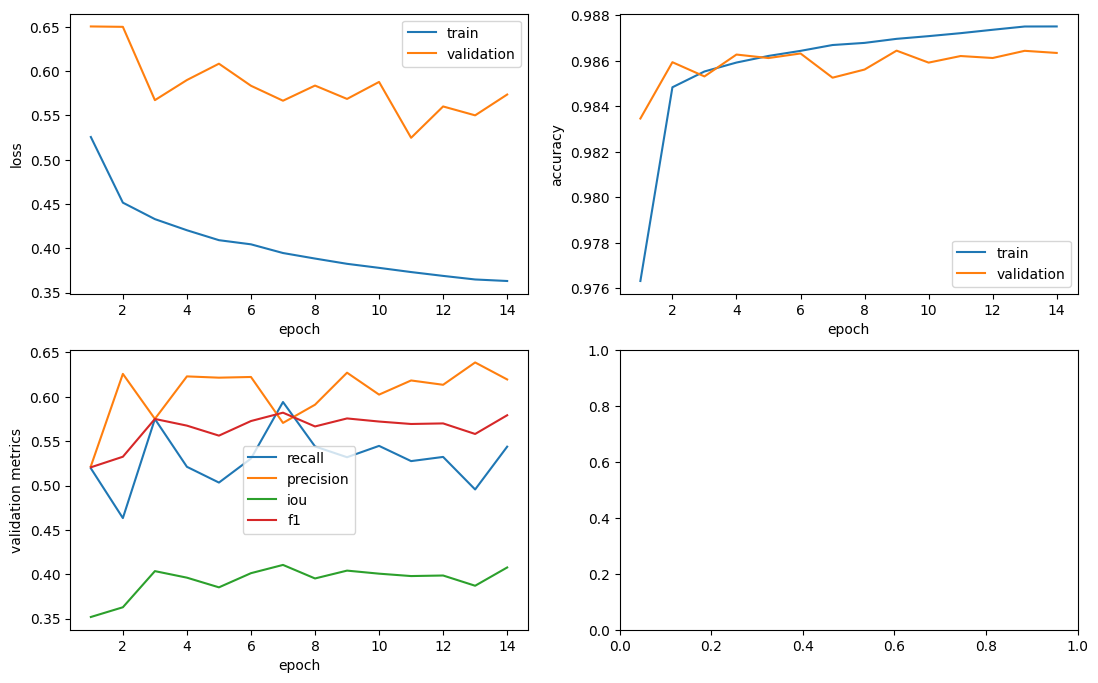

Training 15/15:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating 15/15:   0%|          | 0/210 [00:00<?, ?it/s]

In [ ]:
num_epochs = 15
model = models.segmentation.fcn_resnet50(num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00008, weight_decay=0.0001)
criterion = DiceLoss()
scheduler = None

train_losses, val_losses, train_accuracies, val_accuracies, recalls, precisions, qs, f1s = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs
)

In [17]:
model = models.segmentation.fcn_resnet50(num_classes=2).to(device)

checkpoint = torch.load('/kaggle/working/checkpoint')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [18]:
@torch.no_grad()
def plot_results(dataset, n_examples):
    
    fig, ax = plt.subplots(n_examples, 3, figsize=(15, 5 * n_examples))
    
    model.eval()
    
    inds = np.random.choice(len(dataset), n_examples)
    
    for i in range(n_examples):
        img, m = dataset[inds[i]]
    
        ax[i, 0].imshow((img * 0.5 + 0.5).permute(1, 2, 0))
        ax[i, 0].set_title('image №' + str(inds[i]))
        
        ax[i, 1].imshow(m, cmap='gray', vmin=0, vmax=1)
        ax[i, 1].set_title('ground truth №' + str(inds[i]))
            
        img = img.unsqueeze(0).to(device)
        predicted_m = model(img)['out'].argmax(dim=1).squeeze().cpu()
        
        ax[i, 2].imshow(predicted_m, cmap='gray', vmin=0, vmax=1)
        ax[i, 2].set_title('predicted mask №' + str(inds[i]))
    
    for i in range(n_examples):
        for j in range(3):            
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    
    plt.plot()

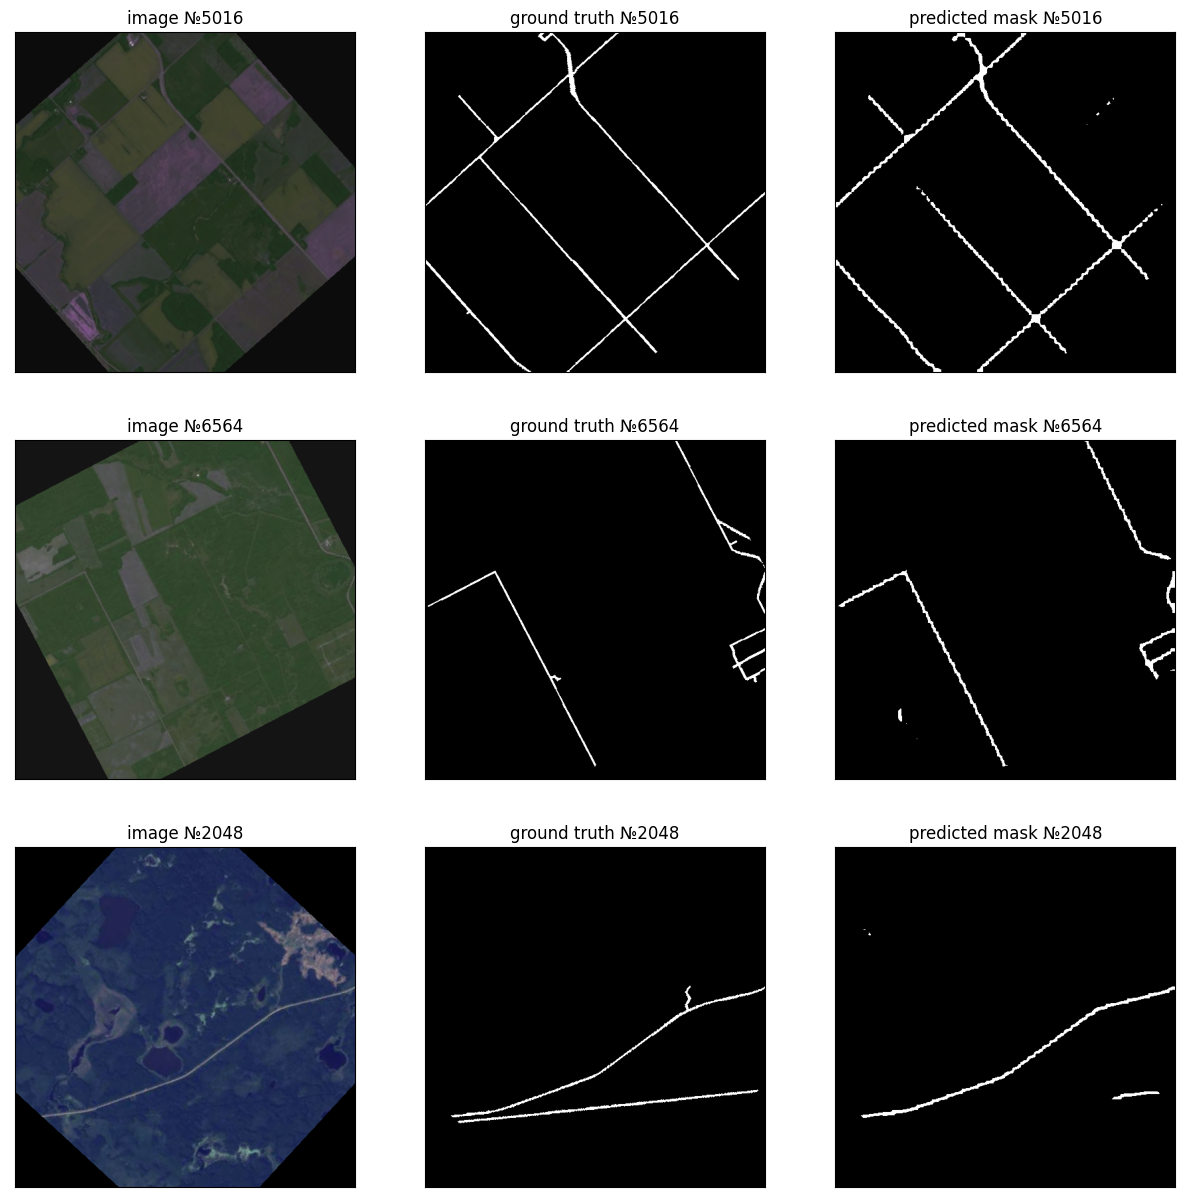

In [19]:
plot_results(train_dataset, n_examples=3)

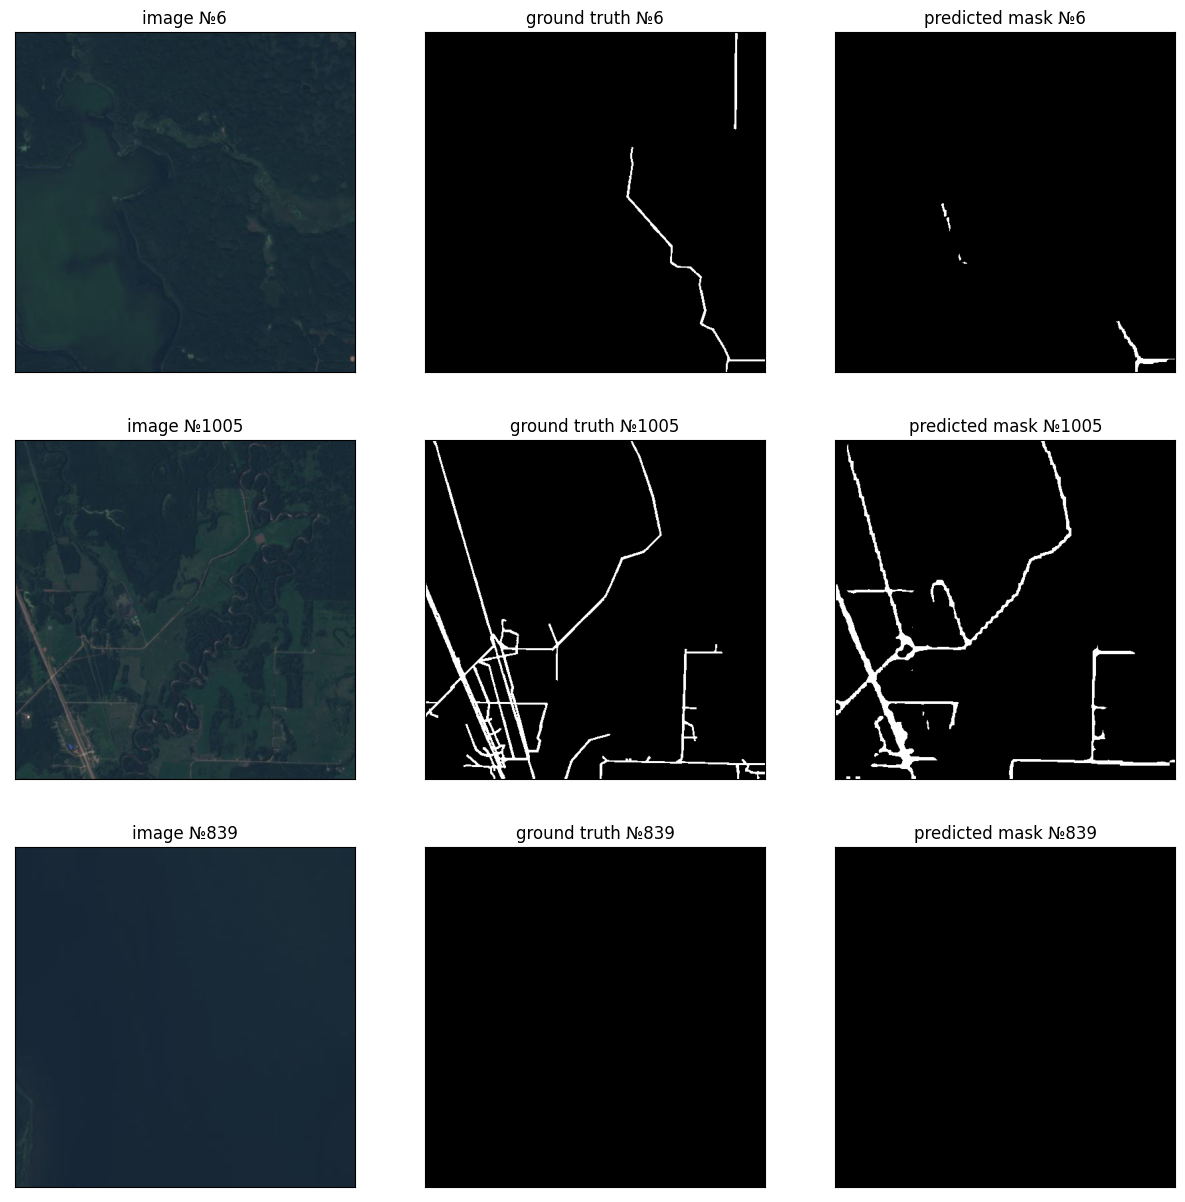

In [20]:
plot_results(val_dataset, n_examples=3)

In [21]:
test_dataset = ForestRoadsDataset('/kaggle/input/coursework/data/test/test_info.csv', 
                                   '/kaggle/input/coursework/data/test', 
                                   common_val_transforms, val_image_transforms, val_mask_transforms)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

In [22]:
with torch.no_grad():
    tp, fn, tn, fp = 0, 0, 0, 0
    
    model.eval()
    
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)['out']
        
        labels = logits.argmax(dim=1)
        labels_masks = (labels == masks)
        labels_not_masks = torch.logical_not(labels_masks)
        labels0 = (labels == 0)
        labels1 = torch.logical_not(labels0)
        
        tp += torch.logical_and(labels_masks, labels1).sum().item()
        fn += torch.logical_and(labels_not_masks, labels0).sum().item()
        tn += torch.logical_and(labels_masks, labels0).sum().item()
        fp += torch.logical_and(labels_not_masks, labels1).sum().item()        
    
accuracy = ((tp + tn) / (test_dataset[0][0].shape[-1]**2)) / len(test_loader.dataset)
recall = tp / (tp + fn + 1e-16)        
precision = tp / (tp + fp + 1e-16)
q = tp / (tp + fn + fp + 1e-16)
f1 = 2*tp / (2*tp + fn + fp + 1e-16)

print('accuracy: %0.5f' % accuracy)
print('recall: %0.5f' % recall)
print('precision: %0.5f' % precision)
print('iou: %0.5f' % q)
print('f1: %0.5f' % f1)

accuracy: 0.98679
recall: 0.57628
precision: 0.60372
iou: 0.41812
f1: 0.58968


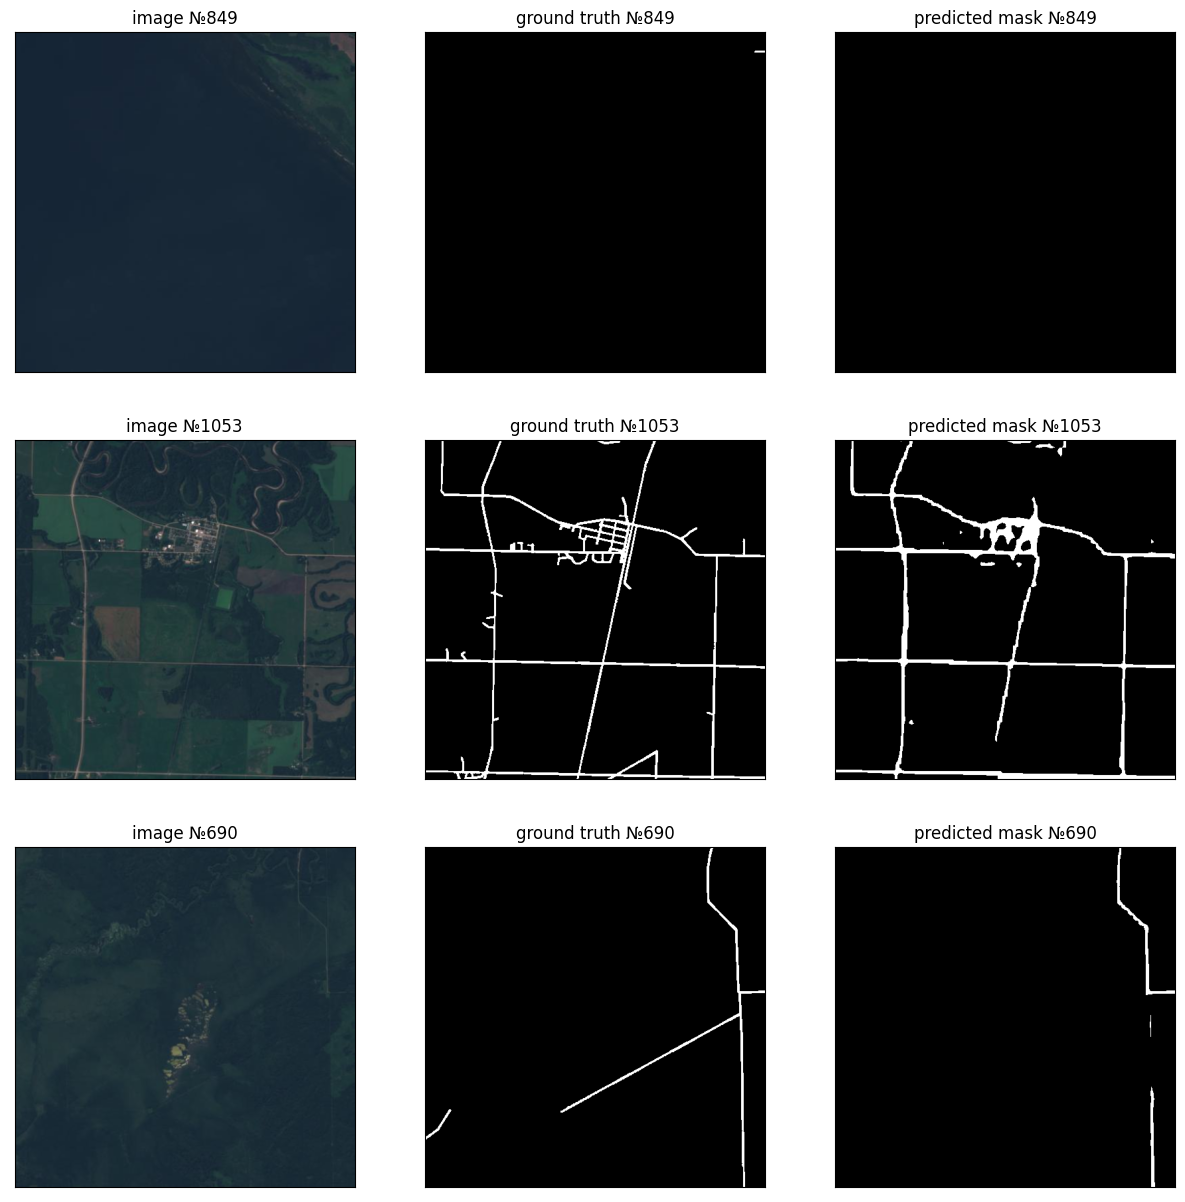

In [23]:
plot_results(test_dataset, n_examples=3)

In [24]:
torch.save(model, '/kaggle/working/fcn')

In [25]:
model = torch.load('/kaggle/input/fcn-net/fcn')
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [26]:
test_dataset = ForestRoadsDataset('/kaggle/input/coursework/data/test/test_info.csv', 
                                   '/kaggle/input/coursework/data/test', 
                                   common_val_transforms, val_image_transforms, val_mask_transforms, 50)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

In [27]:
from torch.ao.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.ao.quantization import QConfigMapping

device = torch.device('cpu')
model = model.to(device)
model.eval()

qconfig = get_default_qconfig('qnnpack')
qconfig_mapping = QConfigMapping().set_global(qconfig)
def calibrate(model, data_loader):
    model.eval()
    with torch.no_grad():
        for image, target in data_loader:
            model(image)
example_inputs = (next(iter(train_loader))[0]) 
prepared_model = prepare_fx(model, qconfig_mapping, example_inputs)  
calibrate(prepared_model, test_loader)  
quantized_model = convert_fx(prepared_model)  

In [28]:
model = quantized_model

In [29]:
with torch.no_grad():
    tp, fn, tn, fp = 0, 0, 0, 0
    
    model.eval()
    
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)['out']
        
        labels = logits.argmax(dim=1)
        labels_masks = (labels == masks)
        labels_not_masks = torch.logical_not(labels_masks)
        labels0 = (labels == 0)
        labels1 = torch.logical_not(labels0)
        
        tp += torch.logical_and(labels_masks, labels1).sum().item()
        fn += torch.logical_and(labels_not_masks, labels0).sum().item()
        tn += torch.logical_and(labels_masks, labels0).sum().item()
        fp += torch.logical_and(labels_not_masks, labels1).sum().item()        
    
accuracy = ((tp + tn) / (test_dataset[0][0].shape[-1]**2)) / len(test_loader.dataset)
recall = tp / (tp + fn + 1e-16)        
precision = tp / (tp + fp + 1e-16)
q = tp / (tp + fn + fp + 1e-16)
f1 = 2*tp / (2*tp + fn + fp + 1e-16)

print('accuracy: %0.5f' % accuracy)
print('recall: %0.5f' % recall)
print('precision: %0.5f' % precision)
print('iou: %0.5f' % q)
print('f1: %0.5f' % f1)

accuracy: 0.99650
recall: 0.58128
precision: 0.60800
iou: 0.42282
f1: 0.59434


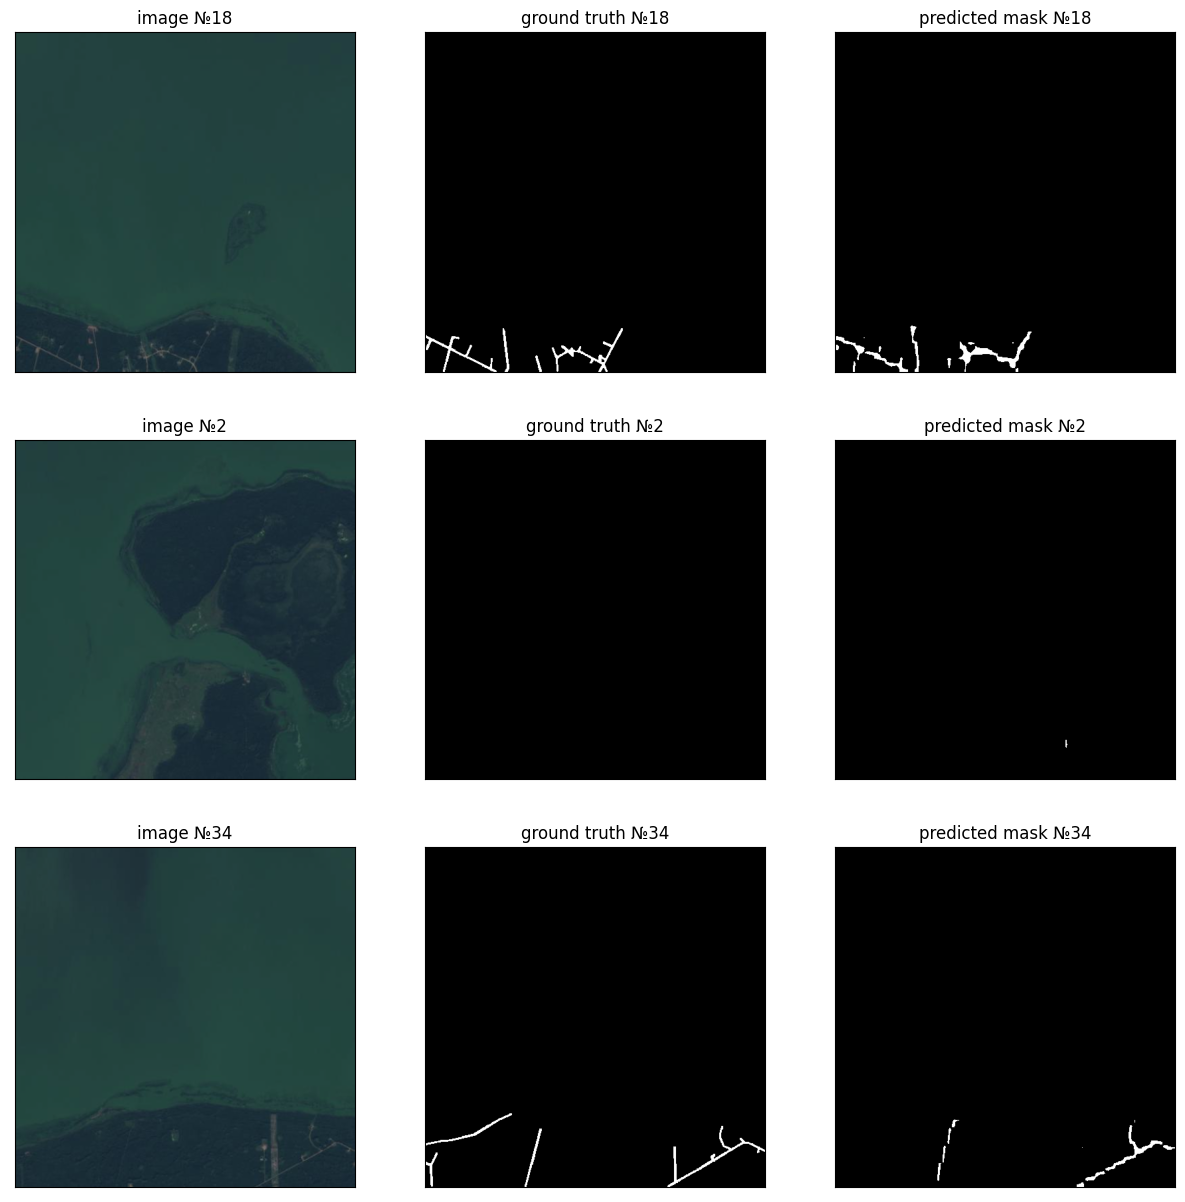

In [30]:
plot_results(test_dataset, n_examples=3)

In [31]:
from torch.utils.mobile_optimizer import optimize_for_mobile

device = torch.device('cpu')
model = model.to(device)
model.eval()

dummy_input = torch.rand(1, 3, 512, 512).to(device)

torchscript_model = torch.jit.script(model)
optimized_torchscript_model = optimize_for_mobile(torchscript_model)
optimized_torchscript_model._save_for_lite_interpreter("optimized_torchscript_model_fcn_quant.ptl")

/opt/conda/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "
